## Support Vector Machine Intraday Trading Strategy eMini S&P500 Futures

In the following steps, an Intraday Trading Strategy for the eMini S&P500 Futures is set up using a Machine Learning Support Vector Machine (SVM) Classifier Python framework. The SVM Classifier will apply a feature set of indicators to predict either a Buy, Sell or Hold signal for the next period.<br>
A Support Vector Machine Classifier is a 'supervised' Machine Learning algorithm (method). 'Supervised' means that it is first trained on historical data (such as past financial market data) to learn which predictive factors influence a future outcome. Subsequently, the trained SVM Classifier is then applied to new or unseen data in an attempt to make predictions based on prior training.<br>
Other supervised Machine Learning methods/algorithms include Deep Learning Neural Networks, XGBoost etc, trading strategies for which will be presented later.<br>
There are also 'unsupervised' Machine Learning methods, where no training is required or done. Unsupervised ML is often studied in an attempt to group data into clusters based on common criteria, for example to identify similar assets to optimize portfolio allocation, or likely default candidates. K-Means Clustering is a popular unsupervised ML method and will also be presented later in the context of a trading strategy.<br>

Key steps involved in creating the SVM Classifier intraday trading strategy are:

1. Import the standard Python libraries and libraries for Machine Learning and Technical Indicators
2. Fetch the historical intraday data for the eMini S&P500 Futures that will be used to train and test the SVM Classifier model (a model is defined as the encoding / programming of a trading strategy):
    - 15-minute intraday (Open, High, Low, Close) Prices and (Up, Down) Volume from May 5, 2006 to May 5, 2020
3. Establish the INPUT Feature Set of Technical Analysis Indicators
4. Establish an OUTPUT Buy, Sell, Hold Signal to be predicted
5. Initialize the Support Vector Machine Classifier model
6. Split the historical data into two sets:
    - one dataset to Train the SVM model and
    - another Test dataset for the trained model to use to make predictions on.
7. Train the SVM Classifier model
8. Run the trained SVM Classifier model on the Test dataset to make predictions and to determine the prediction accuracy
9. Compare the Market Return to the Trading Strategy Return
10. Plot the results


### Import Python Libraries
1. The standard Python libraries are pandas, numpy and matplotlib
2. Scikit-learn (sklearn) is an open source Python machine learning library that provides supervised and unsupervised learning algorithms such as SVM. 
It also provides various tools for model fitting, data preprocessing, model selection and evaluation, 
and many other utilities.
3. TA-lib includes 150+ technical analysis indicators such as ADX, MACD, RSI, Stochastic, Bollinger Bands, etc. and is widely used by Python trading software developers who need to perform technical analysis of financial market data.

In [ ]:
# Python Support Vector Machine Classifier (Machine Learning) eMini SP500 Futures Trading Strategy
# Copyright Sheikh Pancham January 2020 sheikh.pancham@gmail.com

# Maximize Jupyter Notebook Display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import the standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC # import SVC class which will be used to instantiate a support vector classifier.
from sklearn.preprocessing import scale # import scale to scale feature set
import talib as ta

### Object-Oriented Programming (OOP) Approach
An Object-Oriented Programming approach (OOP) is taken here. First, an SVCTradingStrategy class is defined. Then required class methods are developed to get the data, prepare the input feature set, establish the output signal, split the data into separate training and test datasets, initialize the SVM classifier model, train the model using the train dataset , run the prediction on the test dataset, evaluate the strategy performance, and finally plot the results. 

The data used to develop this trading strategy is the eMini S&P500 Futures 15-minute intraday data from May 6, 2006 to May 6, 2019. This is the 15-minute intraday data from the official S&P500 Futures exchange (i.e. 8:30am - 3:30pm on the Chicago Mercantile Exchange (CME)). The contract used is the Continuous eMini S&P500 Futures contract which means the contract is automatically rolled. 

The data is read straight into a pandas dataframe, df, from a csv file using pandas.read_csv(). 
The data columns are Date, Time, Open, High, Low, Close, Up Volume, Down Volume. A datetime index is created from Date and Time.

In [ ]:
class SVCTradingStrategy():
    
    def __getData__(self):
        # Retrieve historical intraday data for USD eMini SP500 Futures
        csv_file ='es.d.15m.15yrs.exchange.csv'
        self.df = pd.read_csv(csv_file, parse_dates=[['Date', 'Time']])
        self.df.index = pd.to_datetime(self.df['Date_Time'])
        print(self.df.head())

## The Signal (Buy, Sell, Hold)
In any trading strategy, the most recent data and also historical price data in hand are used to predict what to do in the next period, that is, whether to Buy, Sell, or Hold (BSH). For instance, if you are developing a daily trading strategy, the Open, High, Low, Close and Volume (OHLCV) at the end of the current day (and previous daily data) are used to determine whether you should Buy, Sell, or Hold at the Open of the next day.<br>
Similarly, in a 15-minute intraday trading strategy, the OHLCV of the 15-minute period/bar just ended (and all previous price data) is used to determine whether to BSH at the Open of the next 15-minute period/bar. The code is the same, only the input data for the trading timeframe is different.<br>
The Machine Learning SVM Classification strategy, therefore, has to be trained to use the current and historical (OHLCV) data to predict the next period return. The next period Market Return is calculated. These are 15-minute market returns. This will be used to determine the signal (BSH) that we want to predict.<br>
The Signal that the ML strategy needs to predict has three classifications - Buy, Sell, Hold. If the next period Market Return we are training on is greater than zero, then the Signal is 1, which will be to Buy. If the next period Market Return is less than zero, then the Signal is -1, which will be to Sell. Otherwise, the Signal is zero, which is do nothing or Hold.<br>
Technically, we use the next period LOG return. And the Signal will be executed on the next Open.<br>
New columns for 'MarketReturn' and 'Signal' are created in the dataframe.

In [ ]:
    def __calculateMarketReturn__(self):
        self.df['MarketReturn'] = np.log(self.df['Open'].shift(-2)/self.df['Open'].shift(-1)) 
    
    def __setSignal__(self):
        self.df['Signal'] = 0
        self.df.loc[self.df['MarketReturn'] > 0, 'Signal'] = 1
        self.df.loc[self.df['MarketReturn'] < 0, 'Signal'] = -1

## Preparing the Feature Set
Now the Feature Set has to be prepared. In Machine Learning (ML), the Feature Set of input data is used to determine the output Signal or Classification. This is similar to how we talk about the set of explanatory X variables in regression analysis that is used to predict the Y output.<br>
The raw feature set data coming in from the CME exchange is the 15-minute intraday Date, Time, Open, High, Low, Close, Up Volume, and Down Volume. This is a sufficient feature set to explore for creating a trading strategy.<br>
However, just for fun we can add some algorithmic and statistical flavor by including a few Technical Indicators from the TA library. You can research and add your own Technical Indicators from the TA library here. To see how this is done, The following technical indicators are added to the feature set:<br>
__RSI__: The Relative Strength Index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of an asset.<br>
__SMA__: A Simple Moving Average (SMA) is an arithmetic moving average calculated by adding recent prices and then dividing that by the number of time periods in the calculation average.<br>
__CORR__: Pearson's correlation coefficient measures the strength and direction of the relationship between two variables, in this case, the time series of Closing prices.<br>
__LINEARREG_SLOPE__: Linear Regression Slope<br>
__STDDEV__: Standard Deviation to capture Volatility of Market Returns.
If desired the OHLC prices can be dropped from the Feature Set, and only the Technical Indicators derived from the OHLC prices can be used.

In [ ]:
    def _prepareFeatureSet_(self):
        self.__calculateMarketReturn__()
        self.__setSignal__()
        self.df = self.df.dropna()
        
        m = 10
        self.df['SMA'] = ta.SMA(np.array(self.df['Close']), timeperiod=m)
        self.df = self.df.dropna()
        self.df['CORREL'] = ta.CORREL(np.array(self.df['High']), np.array(self.df['Low']), timeperiod=m)
        self.df = self.df.dropna()
        
        self.df.loc[self.df['CORREL'] > 1, 'CORREL'] = 1
        self.df.loc[self.df['CORREL'] < -1, 'CORREL'] = -1
    
        self.df['LINEARREG_SLOPE'] = ta.LINEARREG_SLOPE(np.array(self.df['Close'].shift(2)), timeperiod=20)
        self.df = self.df.dropna()
        
        self.df['MOM'] = ta.MOM(np.array(self.df['Close']), timeperiod=m)
        self.df = self.df.dropna()
        
        self.df['STDDEV'] = ta.STDDEV(np.array(self.df['Close']), timeperiod=m, nbdev=1)
        self.df = self.df.dropna()
        
        self.df['RSI'] = ta.RSI(np.array(self.df['Close'].shift(3)), timeperiod=m)
        self.df = self.df.dropna()
        
        self.df['SAR'] = ta.SAR(np.array(self.df['High'].shift(1)), np.array(self.df['Low'].shift(1)), acceleration=0.2, maximum=0.2)
        self.df = self.df.dropna()
        
        self.df['ADX'] = ta.ADX(np.array(self.df['High'].shift(1)), np.array(self.df['Low'].shift(1)), np.array(self.df['Open']), timeperiod=m)
        self.df = self.df.dropna()
        
        # Use the returns for the last 20 15-minute intervals
        n = 20
        for i in range(1, n):
            self.df['MarketReturn%i' % i] = self.df['MarketReturn'].shift(i)
        
        self.df = self.df.dropna()
#         self.X = self.df.drop(['Date_Time','MarketReturn','Signal'], axis=1)
        self.X = self.df.drop(['Date_Time','Open','Close','High','Low','MarketReturn','Signal'], axis=1)
        self.Y = self.df['Signal']

## Scaling and Splitting the Train and Test Datasets
The feature dataset (OHLCV, RSI, SMA, etc) contains features varying in magnitudes, units and range. If left alone, the Machine Learning algorithm only takes in the magnitude of features neglecting the units. The results would vary greatly between different units. The features with high magnitudes will weigh in a lot more  than features with low magnitudes. To supress this effect, we need to bring all features to the same level of magnitudes. This can be achieved by scaling. The scale() function from the sklearn library is used to perform scaling on the feature dataset. <br>
Next, the data for the Feature Set then has to be split into a training dataset and a test dataset. Usually, data scientists would simply use Python train_test_split() to split the data into the first 80% to be used for training 
the ML model and the remaining 20% of data to be used to test the model that was trained. <br> 
Here though, we give the data scientist the flexibility of partitioning the training dataset and test dataset. For instance, they may want to assess how a ML model trained during the Credit Crisis (2006-2010) would perform during the Trump years (2016-  ), or how a ML model trained prior to the Covid-19 Pandemic would perform during the Pandemic months.<br>
Hence, there are customizable begin and end dates for the training dataset, and customizable begin and end dates for the test dataset.

In [ ]:
    def _Scale_Train_Test_Split_(self):
#         Scale and Split Train and Test Data Sets
        self.begintraindt = '2019-11-22'
        self.endtraindt = '2020-04-03'
        self.begintestdt ='2020-04-03'
        self.endtestdt = '2020-05-06'      
        self.X_scaled = pd.DataFrame(scale(self.X), columns=self.X.columns, index=self.df.index)
        self.X_train = pd.DataFrame(self.X_scaled.loc[self.begintraindt : self.endtraindt], columns=self.X_scaled.columns)
        self.Y_train = self.Y[self.begintraindt : self.endtraindt]
        self.X_test = pd.DataFrame(self.X_scaled.loc[self.begintestdt : self.endtestdt], columns=self.X_scaled.columns)
        self.Y_test = self.Y[self.begintestdt : self.endtestdt]

## Instantiate and Train the Support Vector Machine Classifier
We first instantiate the SVM Classifier model providing it with its hyperparameters (C, gamma, kernel). In a Machine Learning model a number of 
parameters are learned from the model during training. However, there are some parameters, known as hyperparameters that cannot be directly learned. 
The hyperparameters must be provided by the data scientist commonly chosen based on some intuition or trial before the actual training begins. 
There are also ways to find the optimal hyperparameters before the actual training begins.  But we shall take up that task in a later discussion.<br>
The hyperparameters for a SVM Classifier model are c, gamma, kernel. The inputs used here SVC(C=1000, gamma='auto', kernel='rbf'). <br>
Click here for the definitions and an interesting study on SVM hyperparameters.<br>
The SVM Classifier model is then trained on the training dataset set selected by the data scientist, and the training accuracy recorded. For SVM, the training
accuracy should be at least 80% accurate. Incidentally, in sklearn the training exercise is called 'fitting' the training set.

In [ ]:
    def _fitCLS_(self):
        self.cls = 0
        self.cls = SVC(C=1000, gamma='auto', kernel='rbf')
        self.cls.fit(self.X_train, self.Y_train)
        self.train_accuracy = self.cls.score(self.X_train, self.Y_train)
        print('SVC Train Accuracy = {:.4f}'.format(self.train_accuracy))

## PREDICT: Run the trained SVM Classifier on the Test dataset to Predict the Signals
Once the SVM Classifier has been trained on the training dataset, we are now ready to make predictions on the test dataset. To do so, we use sklearn predict() method. The trained SVM Classifier is run on the test feature dataset to predict the Signals (BSH).<br>
Column 'PredictSignal' is created to save the predicted signals. The Prediction accuracy is calculated and for a good strategy model this should be above 80%. Less than 80% would not be a model with reliable predictive accuracy.<br>
The data scientist can also run the SVM Classifier on the training data to have prediction signals for the entire dataset to see the whole picture. The prediction accuracy is of course expected to be better on the train dataset, since the model was trained on that, compared to the test dataset.

In [ ]:
    def _predictCLS_(self):
        self.Y_predict = 0
        self.Y_predict = self.cls.predict(self.X_test)
        self.test_accuracy = self.cls.score(self.X_test, self.Y_test)
        print('SVC Test Accuracy = {:.4f}'.format(self.test_accuracy))
        self.df['PredictSignal'] = 0
        self.df.loc[self.begintraindt : self.endtraindt, 'PredictSignal'] = self.cls.predict(self.X_train)
        self.df.loc[self.begintestdt : self.endtestdt, 'PredictSignal'] = self.Y_predict

## Compare the Strategy Return to the Market Return
Recall this is an intraday 15-minute trading strategy so a BSH signal will be generated every
every 15 mins during the market trading day. To evaluate the relative performance of the SVM trading strategy,
the Cumulative Market Return is compared to the Cumulative Strategy Return over the period of
test dataset only. <br>
The 15-minute Market Return was calculated from before. Sum up all of the 15-minute returns over the 
test dataset period to get the Cumulative Market Return.
To get the 15-minute Strategy Return, multiply the 15-minute Market Return by the Signal generated.<br>
Then sum up all the 15-minute strategy returns over the test dataset period to get the Cumulative
Strategy Return.<br>
Plot the Cumulative Strategy Return VS the Cumulative Market Return. The Strategy Return is almost four times the 
Market Return and the Sharpe Ratio greater than 3 which are both highly desired outcomes. A Sharpe Ratio 
less than 2 is not encouraging. Still, however, this is not a recommended strategy and needs some work as the test
accuracy on the test dataset is less than 70%.

In [30]:
    def _calculateStrategyReturn_(self):
        self.df['StrategyReturn'] = 0.0
        self.df['StrategyReturn'] = self.df.loc[self.begintestdt : self.endtestdt, 'MarketReturn'] * self.df.loc[self.begintestdt : self.endtestdt, 'PredictSignal']
        
    def _calculateCumulativeMarketReturn_(self):
        self.df['CumulativeMarketReturn'] = 0.0
        self.df['CumulativeMarketReturn'] = np.cumsum(self.df.loc[self.begintestdt : self.endtestdt, 'MarketReturn'])
        
    def _calculateCumulativeStrategyReturn_(self):
        self.df['CumulativeStrategyReturn'] = 0.0
        self.df['CumulativeStrategyReturn'] = np.cumsum(self.df.loc[self.begintestdt : self.endtestdt, 'StrategyReturn'])
        
    def _plotCumulativeReturn_(self):
        Stdv = np.std(self.df.loc[self.begintestdt : self.endtestdt, 'CumulativeStrategyReturn'])
        print 'Stdv:', Stdv
        Sharpe = (self.df['CumulativeStrategyReturn'].iloc[-1] - self.df['CumulativeMarketReturn'].iloc[-1]) / Stdv
        print 'Sharpe Ratio:', Sharpe
        print 'Strategy Return:', self.df['CumulativeStrategyReturn'].iloc[-1]
        print 'Market Return:', self.df['CumulativeMarketReturn'].iloc[-1]
        plt.plot(self.df['CumulativeStrategyReturn'], color='g', label='Strategy Return')
        plt.plot(self.df['CumulativeMarketReturn'], color='b', label='Market Return')
        plt.legend(loc='best')
        plt.title(str(' SVC Strategy Return ('+self.begintestdt+' - '+self.endtestdt+')'))
        plt.ylabel('Cumulative Return')
        plt.grid()
        plt.show()
        
    def calculateSVCStrategyReturn(self):
        self.__getData__()
        self._prepareFeatureSet_()
        self._Scale_Train_Test_Split_()
        self._fitCLS_()
        self._predictCLS_()
        self._calculateStrategyReturn_()
        self._calculateCumulativeMarketReturn_()
        self._calculateCumulativeStrategyReturn_()
        self._plotCumulativeReturn_()

                              Date_Time     Open     High      Low    Close  \
Date_Time                                                                     
2005-05-06 08:45:00 2005-05-06 08:45:00  1118.50  1118.75  1116.00  1117.25   
2005-05-06 09:00:00 2005-05-06 09:00:00  1117.25  1118.75  1115.25  1117.25   
2005-05-06 09:15:00 2005-05-06 09:15:00  1117.25  1118.00  1113.75  1114.75   
2005-05-06 09:30:00 2005-05-06 09:30:00  1114.75  1117.25  1114.25  1116.50   
2005-05-06 09:45:00 2005-05-06 09:45:00  1116.75  1117.75  1115.00  1115.25   

                        Up   Down  
Date_Time                          
2005-05-06 08:45:00  23504  31838  
2005-05-06 09:00:00  24471  25606  
2005-05-06 09:15:00  22001  31117  
2005-05-06 09:30:00  24035  18834  
2005-05-06 09:45:00  11634  15385  
SVC Train Accuracy = 0.9766
SVC Test Accuracy = 0.5444
Stdv: 0.0964695453047
Sharpe Ratio: 3.1026818906
Strategy Return: 0.417482578204
Market Return: 0.118168266993


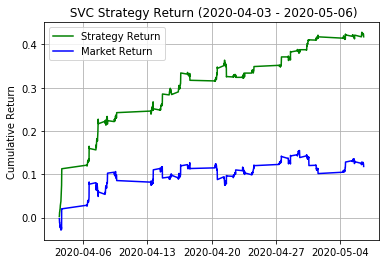

In [31]:
svc = SVCTradingStrategy()
svc.calculateSVCStrategyReturn()

## Explore the SVM Classifier Trading Strategy further
This Support Vector Machine Classifier trading strategy can be explored further in many ways:<br>
1. Experiment with your own Technical Analysis Indicators from the TA library or create your own.
2. Try it on different datasets for Stocks, FX, other Futures and Commodities etc.
3. Try it on different timeframes, e.g. Daily, Monthly etc.<br>
4. Try out different values for the SVM hyperparameters c and gamma.

Coming up, we shall implement Deep Learning Neural Networks and XGBoost Trading Strategies.<br>
And discuss further the Tuning of Hyperparameters.<br>